# librarys

In [119]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import math
import random
import warnings
warnings.simplefilter('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from skrebate import ReliefF
from sklearn.model_selection import cross_val_score
from numpy import array
from mlxtend.feature_selection import ColumnSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
import pydotplus
from sklearn import svm
from sklearn.externals.six import StringIO  
from mlxtend.plotting import plot_confusion_matrix

# functions

In [79]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    #     print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
#     print('Kappa: {:.3f}'.format(cohen_kappa_score(y_test, y_pred)))
# #     print('F1 socre: {:.3f}'.format(f1_score(y_test, y_pred)))
# #     print('Recall socre: {:.3f}'.format(recall_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    return(accuracy_score(y_test, y_pred))

In [8]:
def density_plot(locations, data, element):
    # Iterate through the 6 locations
    for location in locations:
        # Subset to the locations
        subset = data[data['lv'] == location]

        # Draw the density plot
#         sns.distplot(subset[element], hist = False, kde = True,

#                      label = location)
        sns.kdeplot(subset[element], bw = 0.1, label = location)
    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'locations')
    plt.title('Density Plot')
    plt.xlabel(element)
    plt.ylabel('Density')
    

# data import and splitting for reliefF

In [10]:
# data = pd.read_csv("/Users/analytical/Documents/GitHub/Rice_authenticity_ICP_new/grand.csv") # this is for on mac
data = pd.read_csv("C:/Users/fzkon/Documents/GitHub/Rice_authenticity_ICP_new\grand.csv")
x, y = data.drop("lv", axis = 1).values, data["lv"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 233)

In [27]:
data['lv'].value_counts()

PJ-1    35
WC      20
SY      20
PJ-2    20
JS      20
GG      16
Name: lv, dtype: int64

In [35]:
y_train=pd.Series(y_train)
len(y_train)

104

In [36]:
y_test=pd.Series(y_test)
y_test.value_counts()
len(y_test)

27

# Relief feature selection

In [33]:
fs = ReliefF(n_jobs=-1, n_neighbors=len(x_train))
fs.fit(x_train,y_train)

ReliefF(discrete_threshold=10, n_features_to_select=10, n_jobs=-1,
        n_neighbors=104, verbose=False)

In [34]:
relief_result = pd.DataFrame(columns = ['feature', 'score'])

relief_result['score'] = fs.feature_importances_

relief_result['feature'] =data.columns[1:31]

relief_result.sort_values(by=['score'], ascending=False)

,feature,score
3,Al,0.408064
20,Rb,0.364558
0,B,0.355740
1,Na,0.349926
21,Sr,0.338833
8,V,0.334951
22,Nb,0.311015
11,Fe,0.304529
27,Ba,0.265368
10,Mn,0.262424


In [134]:
relief_result = relief_result.sort_values(by=['score'], ascending=False)
relief_result.to_csv("C:/Users/fzkon/Documents/GitHub/Rice_authenticity_ICP_new/relief_result_python.csv", index=False)

# hyperparameter optimization for rf

In [11]:
# relief_result = pd.read_csv("/Users/analytical/Documents/GitHub/Rice_authenticity_ICP_new/relief_result_python.csv") #this is for running on mac

relief_result = pd.read_csv("C:/Users/fzkon/Documents/GitHub/Rice_authenticity_ICP_new/relief_result_python.csv")
relief_result = relief_result.sort_values(by=['score'], ascending=False)
x = data.loc[:, data.columns != 'lv']
y = data.loc[:, data.columns == 'lv']

In [14]:
summary = pd.DataFrame(columns=['number of features', 'training accuracy', 'testing accuracy'])

In [22]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [int(x) for x in np.linspace(start=1, stop = 50, num = 5)],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
    }
rf = RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)
summary = pd.DataFrame(columns=['number of features', 'training accuracy', 'testing accuracy'])

training_accuracy =[]
testing_accuracy = []
features = []

for i in range(1, x.shape[1]+1):
    mask = relief_result['feature'][0:i]
    x_temp = x[mask]
    features.append(list(mask))
    x_train, x_test, y_train, y_test = train_test_split(x_temp, y, test_size = 0.2, random_state = 23)
    grid_search.fit(x_train, y_train)
    training_accuracy.append(grid_search.best_score_)
    if(grid_search.best_score_ == 1):
        print("now i have 100% training accuracy with the following parameters:")
        print(grid_search.best_params_)
        best_grid = grid_search.best_estimator_
        grid_accuracy = evaluate(best_grid, x_test, y_test)
        testing_accuracy.append(grid_accuracy)
        print("my testing accuracy is", grid_accuracy)
        break    
    best_grid = grid_search.best_estimator_
    grid_accuracy = evaluate(best_grid, x_test, y_test)
    testing_accuracy.append(grid_accuracy)
    print("i am in cycle of", i)
    print("my testing accuracy is", grid_accuracy)
    print("now i have 100% training accuracy with the following parameters:")
    print(grid_search.best_params_)
    

summary['number of features'] = features

    

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.0min finished


i am in cycle of 1
my testing accuracy is 0.5555555555555556
now i have 100% training accuracy with the following parameters:
{'bootstrap': True, 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 100}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.9min finished


i am in cycle of 2
my testing accuracy is 0.7037037037037037
now i have 100% training accuracy with the following parameters:
{'bootstrap': True, 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 100}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.0min finished


i am in cycle of 3
my testing accuracy is 0.7777777777777778
now i have 100% training accuracy with the following parameters:
{'bootstrap': True, 'max_depth': 13, 'max_features': 'sqrt', 'n_estimators': 300}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.9min finished


now i have 100% training accuracy with the following parameters:
{'bootstrap': True, 'max_depth': 37, 'max_features': 'auto', 'n_estimators': 200}
my testing accuracy is 1.0


In [23]:
summary['number of features'] = features
summary['training accuracy'] = training_accuracy
summary['testing accuracy'] = testing_accuracy
print(summary)

  number of features  training accuracy  testing accuracy
0               [Al]           0.487273          0.555556
1           [Al, Rb]           0.833636          0.703704
2        [Al, Rb, B]           0.921818          0.777778
3    [Al, Rb, B, Na]           1.000000          1.000000


In [32]:
print(summary)

summary.to_csv("C:/Users/fzkon/Documents/GitHub/Rice_authenticity_ICP_new/rf_result.csv", 
               index=True)

  number of features  training accuracy  testing accuracy
0               [Al]           0.487273          0.555556
1           [Al, Rb]           0.833636          0.703704
2        [Al, Rb, B]           0.921818          0.777778
3    [Al, Rb, B, Na]           1.000000          1.000000


## Confusion matrix with rf

In [37]:
mask = relief_result['feature'][0:4]
x_temp = x[mask]
x_train, x_test, y_train, y_test = train_test_split(x_temp, y, test_size = 0.2, random_state = 23)

In [77]:
rf_opt = best_grid.fit(x_train, y_train)

In [99]:
y_pred = rf_opt.predict(x_test)
    #     print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
#     print('Kappa: {:.3f}'.format(cohen_kappa_score(y_test, y_pred)))
# #     print('F1 socre: {:.3f}'.format(f1_score(y_test, y_pred)))
# #     print('Recall socre: {:.3f}'.format(recall_score(y_test, y_pred)))
cm_rf = confusion_matrix(y_test, y_pred)

locations = list(data['lv'].unique())

from matplotlib import cm

fig, ax = plot_confusion_matrix(conf_mat=cm_rf,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                               class_names=locations,
                               cmap = cm.Set1_r,
                               figsize=(5,5))
plt.show()

# hyperparameter optimization for svm

In [120]:
param_grid = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                     'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
              {'kernel':['poly'], 'degree':[0, 1, 2, 3, 4, 5, 6]}
             ]
svm = svm.SVC()
grid_search = GridSearchCV(estimator = svm, param_grid = param_grid, 
                          cv = 10, n_jobs = -1)

summary = pd.DataFrame(columns=['number of features', 'training accuracy', 'testing accuracy'])

training_accuracy =[]
testing_accuracy = []
features = []

for i in range(1, x.shape[1]+1):
    print("i am in the cycle of", i)
    mask = relief_result['feature'][0:i]
    x_temp = x[mask]
    x_train, x_test, y_train, y_test = train_test_split(x_temp, y, test_size = 0.2, random_state = 23)
    grid_search.fit(x_train, y_train)
    best_grid = grid_search.best_estimator_
    grid_accuracy = evaluate(best_grid, x_test, y_test)
    training_accuracy.append(grid_search.best_score_)
    testing_accuracy.append(grid_accuracy)
    features.append(list(mask))
    if grid_search.best_score_ == 1:
        print("i have reached 100% accuracy")
        print(grid_search.best_params_)
        break
    


summary['number of features'] = features
summary['training accuracy'] = training_accuracy
summary['testing accuracy'] = testing_accuracy
    

print(summary)

i am in the cycle of 1
              precision    recall  f1-score   support

          GG       0.00      0.00      0.00         4
          JS       0.40      1.00      0.57         2
        PJ-1       1.00      0.67      0.80         9
        PJ-2       0.67      0.50      0.57         4
          SY       0.33      1.00      0.50         3
          WC       0.75      0.60      0.67         5

    accuracy                           0.59        27
   macro avg       0.53      0.63      0.52        27
weighted avg       0.64      0.59      0.57        27

i am in the cycle of 2
              precision    recall  f1-score   support

          GG       1.00      0.25      0.40         4
          JS       1.00      1.00      1.00         2
        PJ-1       1.00      1.00      1.00         9
        PJ-2       0.50      0.50      0.50         4
          SY       0.25      0.33      0.29         3
          WC       0.71      1.00      0.83         5

    accuracy                   

In [122]:
svm_opt = best_grid.fit(x_train, y_train)

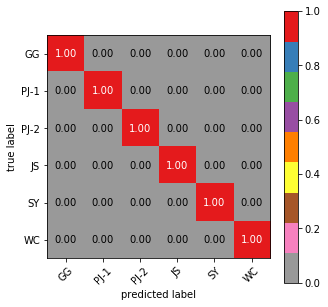

In [132]:
y_pred = svm_opt.predict(x_test)
    #     print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
#     print('Kappa: {:.3f}'.format(cohen_kappa_score(y_test, y_pred)))
# #     print('F1 socre: {:.3f}'.format(f1_score(y_test, y_pred)))
# #     print('Recall socre: {:.3f}'.format(recall_score(y_test, y_pred)))
cm_svm = confusion_matrix(y_test, y_pred)

locations = list(data['lv'].unique())

from matplotlib import cm

fig, ax = plot_confusion_matrix(conf_mat=cm_svm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                               class_names=locations,
                               cmap = cm.Set1_r,
                               figsize=(5,5))
plt.show()

In [64]:
summary.to_csv("/Users/analytical/Documents/GitHub/Rice_authenticity_ICP_new/svm_result.csv", 
               index=True)

## Starting of density plot

In [51]:
locations = ['JS', 'SY', 'WC', 'PJ-1', 'PJ-2', 'GG']

Al

,count,mean,std,min,25%,50%,75%,max
lv,,,,,,,,
GG,16.0,8.624013,0.316711,7.851596,8.442039,8.689004,8.826498,9.069712
JS,20.0,10.522208,0.187829,10.271241,10.428438,10.487114,10.547028,11.141914
PJ-1,35.0,11.126173,0.483185,10.514673,10.684176,10.900764,11.558639,11.875304
PJ-2,20.0,8.329455,0.259466,7.979371,8.093455,8.304393,8.443683,8.993124
SY,20.0,8.624663,0.286979,8.093969,8.425880,8.632160,8.792685,9.199098
WC,20.0,9.001860,0.332381,8.612122,8.756477,8.918600,9.202102,9.648766


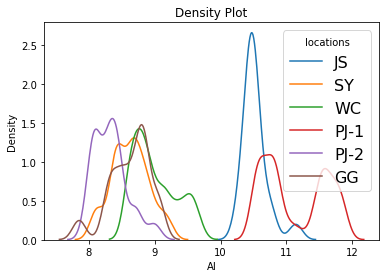

In [79]:
density_plot(locations, data, elements[0])

data.groupby('lv')[elements[0]].describe()

Rb

,count,mean,std,min,25%,50%,75%,max
lv,,,,,,,,
GG,16.0,11.075358,0.352862,10.471864,10.816727,11.057128,11.266772,11.652005
JS,20.0,10.472157,0.115461,10.262857,10.380405,10.485515,10.527730,10.670491
PJ-1,35.0,9.040235,0.239654,8.649233,8.826450,8.996238,9.144450,9.558324
PJ-2,20.0,9.976119,0.252306,9.451244,9.857604,9.963220,10.100789,10.521417
SY,20.0,10.191141,0.401686,9.391915,9.895441,10.275018,10.556983,10.656619
WC,20.0,11.061249,0.121203,10.758231,11.008951,11.066301,11.129656,11.306991


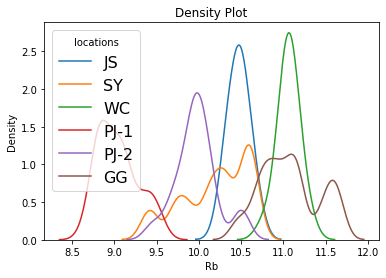

In [80]:
density_plot(locations, data, elements[1])

data.groupby('lv')[elements[1]].describe()

B

,count,mean,std,min,25%,50%,75%,max
lv,,,,,,,,
GG,16.0,8.608929,0.151893,8.414138,8.485398,8.619523,8.713711,8.957043
JS,20.0,8.228153,0.176032,7.949523,8.109330,8.224519,8.341984,8.538336
PJ-1,35.0,9.498883,0.150733,9.271032,9.345774,9.524120,9.602598,9.865923
PJ-2,20.0,8.724303,0.161791,8.531818,8.596108,8.709689,8.799071,9.141318
SY,20.0,8.773493,0.172515,8.413383,8.722515,8.764233,8.877779,9.061104
WC,20.0,8.317846,0.129273,8.081510,8.233997,8.297705,8.400287,8.582795


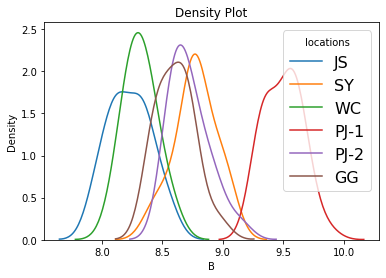

In [81]:
density_plot(locations, data, elements[2])

data.groupby('lv')[elements[2]].describe()

Na

,count,mean,std,min,25%,50%,75%,max
lv,,,,,,,,
GG,16.0,11.018553,0.135075,10.690648,10.964562,11.018809,11.081639,11.284492
JS,20.0,10.198283,0.150670,9.958060,10.112575,10.174899,10.273606,10.556151
PJ-1,35.0,13.692792,0.526023,12.890923,13.410102,13.596794,13.890301,15.277934
PJ-2,20.0,12.542984,0.155666,12.301597,12.420788,12.552847,12.655318,12.814392
SY,20.0,14.270297,0.227569,13.810504,14.124509,14.268878,14.374482,14.731285
WC,20.0,12.364394,0.155194,12.161844,12.254887,12.351063,12.404490,12.767970


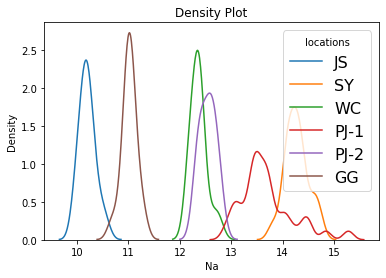

In [82]:
density_plot(locations, data, elements[3])

data.groupby('lv')[elements[3]].describe()

Sr

,count,mean,std,min,25%,50%,75%,max
lv,,,,,,,,
GG,16.0,6.049641,0.310342,5.548267,5.847216,6.093461,6.366289,6.455451
JS,20.0,5.846493,0.135372,5.558666,5.753265,5.853054,5.972913,6.026114
PJ-1,35.0,7.162524,0.235289,6.689166,7.032692,7.107160,7.334919,7.726865
PJ-2,20.0,6.609921,0.099042,6.474712,6.545891,6.588478,6.677076,6.862829
SY,20.0,5.816905,0.145444,5.390736,5.762157,5.813897,5.912568,6.101661
WC,20.0,6.239754,0.131056,5.947503,6.143932,6.225363,6.310253,6.527602


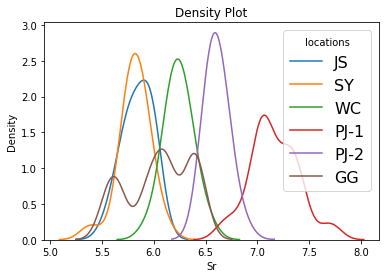

In [83]:
density_plot(locations, data, elements[4])

data.groupby('lv')[elements[4]].describe()

# construction of decision tree 

In [86]:
data['lv'].value_counts()

PJ-1    35
PJ-2    20
SY      20
JS      20
WC      20
GG      16
Name: lv, dtype: int64

In [128]:
relief_result = relief_result.sort_values(by=['score'], ascending=False)

elements = list(relief_result['feature'][0:4])

x_tree = x[elements]

x_names = x_tree.columns
x_names = x_names.tolist()

y_names = ['GG', 'JS', 'PJ-1', 'PJ-2', 'SY', 'WC']

dtc = DecisionTreeClassifier()
sample_split_range = list(range(1, 50))
param_grid = dict(min_samples_split=sample_split_range)
grid = GridSearchCV(dtc, param_grid, cv = 20, scoring='accuracy')
grid.fit(x_tree, y)
tree = grid.best_estimator_


# Extract single tree

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(tree, out_file='tree.dot', 
                feature_names = x_names,
                class_names = y_names,
                rounded = True, proportion = False, 
                precision = 3, filled = True, max_depth=7)

# Convert to png using system command (requires Graphviz)


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [129]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')